In [52]:
from sympy import *
from sympy.solvers import solve
import numpy as np 
import transforms3d as tf3d
from collections import OrderedDict

init_printing()

# Initialisation des fonctions lambdifier pour la simulation
## Lambdification des calculs de Cd et Cl

In [53]:
##################################################### Calcul de l'angle d'attaque et calcul du coefficient sigma qui donne la transition entre le modèle flate plate te small angle #################################
def compute_alpha(dragDirection, liftDirection, frontward_Body, VelinLDPlane):
    absalpha= np.arccos(np.vdot(-dragDirection, frontward_Body))
    alpha = np.sign(np.vdot(-dragDirection, np.array([1,0,0]))) * absalpha
#    if np.linalg.norm(VelinLDPlane)>1e-7 :
#        alpha = signalpha*absalpha 
#    else :
#        alpha=0
#    if abs(alpha)>0.5*np.pi:
#        if alpha>0 :alpha=alpha-np.pi 
#        else: alpha=alpha+np.pi         
    return alpha

    
# Initialisation des paramètres pour les équations symbolique
CL_1_sa = Symbol('C^{sa}_{L,1}',real=True)             # Coeff rechercher
CD_0_sa = Symbol('C^{sa}_{D,0}',real=True)             # Coeff rechercher
CD_1_sa = Symbol('C^{sa}_{D,1}',real=True)             # Coeff rechercher
CD_0_fp = Symbol('C^{fp}_{D,0}',real=True)             # Coeff rechercher
CD_1_fp = Symbol('C^{fp}_{D,1}',real=True)             # Coeff rechercher                     

k_0 = Symbol('k_0', real=True)                         # coeff rechercher
k_1 = Symbol('k_1', real=True)                         # coeff rechercher
k_2 = Symbol('k_2', real=True)                         # coeff rechercher

delta_s = Symbol('delta_s', real=True)                # Coeff rechercher : largeur du stall

alpha_s = Symbol('alpha_s',real=True)                 # Coeff rechercher

##################################################### génération des équations pour Cd et Cl (utiliser pour générer les équations symbolique pour chaque surface portantes) ####################################################
def compute_cl_cd(a, a_0, a_s, d_0, d_s, cl1sa, cd1fp, k0, k1, k2, cd0fp, cd0sa, cd1sa):

    CL_sa = 1/2 * cl1sa * sin(2*(a + (k1*d_0) + a_0))
    CD_sa = cd0sa + cd1sa * sin(a + (k0*d_0) + a_0)*sin(a +  (k0*d_0) + a_0)

    CL_fp = 1/2 * cd1fp * sin(2*(a+ (k1*d_0) + a_0))
    CD_fp = cd0fp + cd1fp * sin(a + (k0*d_0) + a_0)*sin(a +  (k0*d_0) + a_0)

    puiss=5
    s = 1.0 - ((a+a_0)**2/a_s**2)**puiss/(((a+a_0)**2/a_s**2)**puiss + 100+200*d_s)

    C_L = CL_fp + s*(CL_sa - CL_fp) + k2 * sin(d_0)
    C_D = CD_fp + s*(CD_sa - CD_fp)
    return C_L, C_D

In [63]:
s_(0.30)

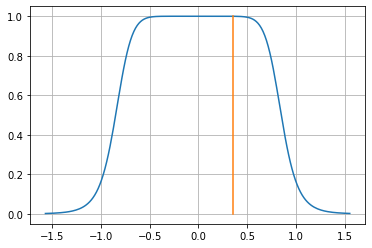

In [60]:
puiss=5
a_0=0
a_s=0.52
a = symbols('a')
d_s = 0.181484
s =- ((a+a_0)**2/a_s**2)**puiss/(((a+a_0)**2/a_s**2)**puiss + 100+200*d_s)
s2 = 1 +s
s_ = lambdify((a), s2)
alp = np.arange(-90,90,1)*np.pi/180
import matplotlib.pyplot as plt
plt.plot(alp,s_(alp))
plt.plot([0.35 for i in np.arange(0,1.1,0.1)],[i for i in np.arange(0,1.1,0.1)])
plt.grid()

## Fonction utiles pour les caluls des efforts aérodynamiques des ailes et des moteurs ainsi que le calcul du gradient : 

In [3]:
################################################### Paramètres pour les équations symboliques pour les efforts aérodynamiques des ailes et des moteurs #######################
B_B       = Matrix([[1,0,0], [0,1,0], [0,0,1]])                              # Base dans le repère body

omega1, omega2, omega3 = symbols('\omega_1, \omega_2, \omega_3', real=True)
Omega     = Matrix([omega1, omega2, omega3])                                 # Vecteur de rotation
 
alpha = Symbol('alpha',real=True)                     # angle d'attaque

r00, r01, r02, r10, r11, r12, r20, r21, r22 = symbols('r_{00}, r_{01}, r_{02}, r_{10}, r_{11}, r_{12}, r_{20}, r_{21}, r_{22}', real=True)
R         = Matrix([[r00,r01,r02], [r10,r11, r12], [r20, r21, r22]])          # Matrice de rotation

Vb1,Vb2,Vb3=symbols('V_{b1} V_{b2} V_{b3}',real=True)
v_B        = Matrix([Vb1, Vb2, Vb3])                                          # Vitesse du corps (repère drone)

Vw1,Vw2,Vw3=symbols('V_{w1} V_{w2} V_{w3}',real=True)                         # Vitesse du vent dans le repère NED 
v_W        = Matrix([Vw1, Vw2, Vw3])

xcp, ycp, zcp = symbols('x_{cp}, y_{cp}, z_{cp}')
X_cp     = Matrix([xcp, ycp, zcp])                                            # Position du centre de poussé d'un corps dans le repère body

C_t, C_q, C_h=symbols('C_t,C_q, C_h',real=True)                           # Coefficient de poussée des moteurs, coefficient de couple des moteurs

motor_axis_in_body_frame = Matrix([1,0,0])                                    # Axe des moteurs, ici placé en mode avion

omega_rotor = symbols('\omega_{rotor}', real=True)                            # Vitesse de rotation des moteurs

frontward_B = B_B[:,0]
upward_B    = B_B[:,2]
crossward_B = B_B[:,1]

c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)

########################################### Les différentes fonctions utilisé pour générer les différentes équations symboliques ###################################################

def GenDirectForceWing(Omega, cp, vB, vW, R, crossward_Body):
    # Cette fonction permet d'obtenir les directions des efforts de portances et de trainé en fonction des vitesses, et de l'orientation dans le repère NED.
    Air_speed_earth = vB - vW 
    Air_speed_body  = (R.T* Air_speed_earth) - cp.cross(Omega)
    VelinLDPlane    = Air_speed_body - Air_speed_body.dot(crossward_Body.T) * crossward_Body
    
    dragDirection = -VelinLDPlane / VelinLDPlane.norm() 
    liftDirection = -crossward_Body.cross(dragDirection) 

    return VelinLDPlane, dragDirection, liftDirection

def GenForceWing(A, VelinLDPlane, dragDirection, liftDirection, Cd, Cl, cp):
    # Cette fonction permet de générer les forces aerodynamique d'une aile dans son repère.
    D = A * VelinLDPlane.norm()**2 * dragDirection * Cd
    L = A * VelinLDPlane.norm()**2 * liftDirection * Cl

    F_wing = L+D 
    Torque_wing =  cp.cross(F_wing)

    return F_wing, Torque_wing

def Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, vB, vW,  Cd_list, Cl_list, crossward_body, r_queue, r_queue_neg):
    # Cette function permet de généer l'équation complète de la somme des forces pour les différentes surfaces portantes 
    p = 0
    Sum_Force_Wing = Matrix([0,0,0])
    Sum_Torque_Wing =  Matrix([0,0,0])
    for i in cp_list:
        VelinLDPlane, dragDirection, liftDirection= GenDirectForceWing(Omega, i, vB, vW, R_list[p], crossward_body)
        if p == 2 :
            # Comme la fonction GenForceWing donne les efforts des ailes dans leur repère propre, on doit passer par les matrice de rotation pour les ailes de la queue
            F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], Matrix([0,0,0]))
            Sum_Force_Wing  = Sum_Force_Wing +  r_queue  @ F_wing 
            Sum_Torque_Wing = Sum_Torque_Wing + i.cross(r_queue  @ F_wing) 
        elif p == 3 :
            F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], Matrix([0,0,0]))
            Sum_Force_Wing  = Sum_Force_Wing +  r_queue_neg  @ F_wing 
            Sum_Torque_Wing = Sum_Torque_Wing + i.cross(r_queue_neg  @ F_wing) 
        else:
            F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], i)
            Sum_Force_Wing  = Sum_Force_Wing +  F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + Torque_wing
        p+=1

    return Sum_Force_Wing, Sum_Torque_Wing


def GenForceMoteur(Omega, ct, cq, omega_rotor, cp, vB, vW, ch, R, motor_axis_in_body_frame, spinning_sense):
    ## Cette fonction calcule les effort produit par un rotor sur le drone en fonction de son sens de rotation et de sa localisation, les efforts sont donnés
    ## dans le repère inertiel. l'axe des moteur est placé suivant l'axe x du drone (mode avion seulement)
    Air_speed_earth = vB - vW
    air_speed_in_rotor_frame = (R.T* Air_speed_earth) - cp.cross(Omega)
    Axial_speed = air_speed_in_rotor_frame.dot(motor_axis_in_body_frame)
    lat_speed = air_speed_in_rotor_frame - (Axial_speed * (motor_axis_in_body_frame))
        
    T = ct*omega_rotor**2
    H = ch * omega_rotor
    
    T_vec = T * motor_axis_in_body_frame - H * lat_speed
    
    torque = - omega_rotor * cq * lat_speed
    torque = - spinning_sense * cq * T * motor_axis_in_body_frame 
    torque_at_body_center = torque + cp.cross(T_vec.T)
        
    return T_vec, torque_at_body_center

def Generate_Sum_Force_Moteur(Omega, ct, cq, omega_rotor, cp_list_rotor, vB, vW, ch, R, motor_axis_in_body_frame_list, spinning_sense_list):
    # Calcul des forces des moteurs sur le drone, génère toutes les forces, ainsi que le couple appliqué au centre de gravité du drone, dans le repère inertiel
    p = 0
    Sum_Force_Rotor = Matrix([0,0,0])
    Sum_Torque_Rotor =  Matrix([0,0,0])
    for cp in cp_list_rotor:
        F_rotor, Q_rotor = GenForceMoteur(Omega, ct, cq, omega_rotor, cp, vB, vW, ch, R, motor_axis_in_body_frame_list, spinning_sense_list[p])        
        Sum_Force_Rotor  = Sum_Force_Rotor + F_rotor
        Sum_Torque_Rotor = Sum_Torque_Rotor + Q_rotor
        p+=1

    return Sum_Force_Rotor, Sum_Torque_Rotor


## Génération des équations aérodynamiques du drones

In [4]:
############################################## Initilisation des paramètres pour la génération des équations des ailes ###########################
c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)
r = np.array(((1,0, 0),(0,c45,s45),(0,-s45, c45)))
r_neg     = np.array(((1,0, 0), (0,c45, -s45),(0,s45, c45)))
R_list_sympy = [R, R,  R * r,  R *r_neg, R]      # Liste des matrices de rotation de chaque surface portante du drone, seul les éléments de la queue (element 3 et 4) ne sont pas dans le repère inertiel. 

cp1x,cp1y, cp1z, cp2x,cp2y,cp2z, cp3x,cp3y,cp3z, cp4x,cp4y,cp4z,cp5x,cp5y,cp5z = symbols('cp1x,cp1y, cp1z, cp2x,cp2y,cp2z, cp3x,cp3y,cp3z, cp4x,cp4y,cp4z,cp5x,cp5y,cp5z', real=True)
cp_list = [Matrix([cp1x,cp1y, cp1z]), Matrix([cp2x,cp2y,cp2z]), Matrix([cp3x,cp3y,cp3z]), Matrix([cp4x,cp4y,cp4z]), Matrix([cp5x,cp5y,cp5z])]

A1, A2, A3 = symbols('A_1 A_2 A_3', real=True)
Aire_list = [A1, A1, A2, A2, A3]  # Liste des 1/2 * rho * S pour chaque surface

# Initialisation pour les équations des rotors
cp_list_rotor = [Matrix([0.713,0.475,0]), Matrix([0.713,-0.475,0])]
spinning_sense_list = [1,-1]

# Ces équation servent uniquement pour le calcul de l'angle d'attaque pour le calcul des coeffficient aérodynamique Cd et Cl, il n'interviennent pas directement dans le calcul des efforts. 
VelinLDPlane, dragDirection, liftDirection=  GenDirectForceWing(Omega, X_cp, v_B, v_W, R, crossward_B)

## Lambdification des fonction
VelinLDPlane_function = lambdify((Omega, X_cp, v_B, v_W, R), VelinLDPlane, 'numpy')
dragDirection_function = lambdify((Omega, X_cp, v_B, v_W, R), dragDirection, 'numpy')
liftDirection_function = lambdify((Omega, X_cp, v_B, v_W, R), liftDirection, 'numpy')

## Génération des équation complete en prenant en compte les équations des coeffs aéro dans l'équation finale :

In [5]:
##### Listes des angles (d'attaque et de contrôles) pour faire la somme des forces en une seule équations
alpha1, alpha2, alpha3, alpha4, alpha5 = symbols('alpha_1, alpha_2, alpha_3, alpha_4, alpha_5', real=True)
alpha_list =Matrix([alpha1, alpha2, alpha3, alpha4, alpha5])
alpha0_1, alpha0_2, alpha0_3, alpha0_4, alpha0_5 = symbols('alpha_0_1, alpha_0_2, alpha_0_3, alpha_0_4, alpha_0_5', real=True)
alpha0_list = Matrix([alpha0_1, alpha0_2, alpha0_3, alpha0_4, alpha0_5])
delta0_1, delta0_2, delta0_3, delta0_4, delta0_5 = symbols('delta_0_1, delta_0_2, delta_0_3, delta_0_4, delta_0_5', real=True)
delta0_list = Matrix([delta0_1, delta0_2, delta0_3, delta0_4, delta0_5])
    
##### Cette fonction permet juste de créer une liste de paramètres aéro pour chaques surfaces du drones, elles sont utiliser pour condenser les équations. 
def Compute_list_coeff(alpha_list, alpha_0_list, alpha_s, delta_0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa):
    Cd_list = Matrix([0 for i in range(len(alpha_list))])
    Cl_list = Matrix([0 for i in range(len(alpha_list))])
    for count, alpha in enumerate(alpha_list):
        Cl_list[count],  Cd_list[count] =  compute_cl_cd(alpha, alpha_0_list[count], alpha_s, delta_0_list[count], delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa)
    return Cl_list , Cd_list

Cl_list, Cd_list = Compute_list_coeff(alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa)
##### Dynamique du drone complet en fonctions des paramètres aéro et de sa vitesse 
Sum_F_wing_complete, Sum_T_wing_complete = Generate_Sum_Force_wing(Aire_list, Omega, cp_list, R_list_sympy, v_B, v_W, Cd_list, Cl_list, crossward_B, r, r_neg)

Sum_F_wing_complete_function = lambdify((Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), Sum_F_wing_complete, 'numpy')
Sum_T_wing_complete_function = lambdify((Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), Sum_T_wing_complete, 'numpy')

##################### Sommes des efforts des moteurs
  # Ces équations donnes les équations de la sommes des efforts des moteurs sur le drone dans le repère intertiel
Sum_F_rotor_complete, Sum_T_rotor_complete = Generate_Sum_Force_Moteur(Omega, C_t, C_q, omega_rotor, cp_list_rotor, v_B, v_W, C_h, R, motor_axis_in_body_frame, spinning_sense_list)
Sum_F_rotor_complete.simplify()
Sum_T_rotor_complete.simplify()

##### Fonction qui regroupe les équations aérodynamique du drones complet en une seule équation comprenant le calcul des coeffs aérodynamique en fonction de alpha, utilisé en simulation #####################
Effort_Aero_complete = [Sum_F_wing_complete + Sum_F_rotor_complete , Sum_T_wing_complete + Sum_T_rotor_complete]
Effort_Aero_complete_function = lambdify((Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, C_t, C_q, C_h, omega_rotor), Effort_Aero_complete, 'numpy')


import dill as dill
dill.settings['recurse'] = True

Functions = [VelinLDPlane_function, \
             dragDirection_function, \
             liftDirection_function,\
             compute_alpha,\
             Effort_Aero_complete_function]
dill.dump(Functions, open("../Simulation/function_moteur_physique", "wb"))


## Génération des équations du gradient 

In [6]:
############# Vecteur d'état pour la génération des équations pour le calcul du gradient ##############
for type_grad in ['wind_only','params_plus_wind', 'params']:
    if type_grad=='wind_only':
        theta_alea= { 'wind_X':Vw1,
                      'wind_Y':Vw2,
                    }
    elif type_grad=='params_plus_wind':
        theta_alea={ 'cd1sa':CD_1_sa,
                  'cl1sa':CL_1_sa,
                  'cd0sa':CD_0_sa,
                  'coeff_drag_shift':k_0,
                  'coeff_lift_shift':k_1,
                  'coeff_lift_gain':k_2, 
                  'wind_X':Vw1,
                  'wind_Y':Vw2,
                  }
    elif type_grad=='params':
        theta_alea={ 'cd1sa':CD_1_sa,
                  'cl1sa':CL_1_sa,
                  'cd0sa':CD_0_sa,
                  'coeff_drag_shift':k_0,
                  'coeff_lift_shift':k_1,
                  'coeff_lift_gain':k_2,
                  }


    theta = OrderedDict(sorted(theta_alea.items(), key=lambda t: t[0]))
    Grad_Force_Aero_complete = Matrix([(Effort_Aero_complete[0]).jacobian([i for i in theta.values()])])
    Grad_Torque_Aero_complete = Matrix([(Effort_Aero_complete[1]).jacobian([i for i in theta.values()])])
    Grad_Effort_Aero_complete = [Grad_Force_Aero_complete,Grad_Torque_Aero_complete]

    ########## Equation du gradient utilisé en simulation ####################
    Grad_Effort_Aero_complete_function = lambdify((Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, \
                                                   CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, C_t, C_q, C_h, omega_rotor), Grad_Effort_Aero_complete, 'numpy')
    m=symbols('m', real=True)
    g1,g2,g3=symbols('g1,g2,g3', real=True)
    g=Matrix([g1,g2,g3])
    batch_size=1
    y_data = Matrix([[Symbol('y_data_j_%i'.replace('j',str(j))%i, real=True) for i in range(6)] for j in range(batch_size)])
    w1,w2,w3,w4,w5,w0 = symbols('w_1,w_2,w_3,w_4,w_5,w_0')
    W = Matrix([[w0,0,0,0,0,0],[0,w1,0,0,0,0],[0,0,w2,0,0,0],[0,0,0,w3,0,0],[0,0,0,0,w4,0],[0,0,0,0,0,w5]])

    #Génération des équations finales pour la gradient du cout et des RMS error
    forces = R@(Sum_F_wing_complete + Sum_F_rotor_complete) + m*g
    torque = R@(Sum_T_wing_complete + Sum_T_rotor_complete)
    RMS_forces = ((Matrix(y_data[0:3])-forces).T@W[0:3,0:3]@(Matrix(y_data[0:3])-forces))[0]
    RMS_torque = ((Matrix(y_data[3:])-torque).T@W[3:,3:]@(Matrix(y_data[3:])-torque))[0]
    Cout = (RMS_forces+RMS_torque)
    Grad_Cout = Matrix([Cout]).jacobian([i for i in theta.values()])

    #### Lambdification des fonctions
    RMS_forces_function = lambdify((y_data, Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, \
                                                   CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, C_t, C_q, C_h, omega_rotor, g, m, w0,w1,w2), RMS_forces, 'numpy')
    RMS_torque_function = lambdify((y_data, Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, \
                                                   CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, C_t, C_q, C_h, omega_rotor, g, m, w3,w4,w5), RMS_torque, 'numpy')
    Cout_function=lambdify((y_data, Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, \
                                                   CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, C_t, C_q, C_h, omega_rotor, g, m, w0,w1,w2,w3,w4,w5), Cout, 'numpy')
    Grad_Cout_function=lambdify((y_data, Aire_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, \
                                                   CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, C_t, C_q, C_h, omega_rotor, g, m, w0,w1,w2,w3,w4,w5), Grad_Cout, 'numpy')
    
    import dill as dill
    dill.settings['recurse'] = True

    Functions = [VelinLDPlane_function, \
                 dragDirection_function, \
                 liftDirection_function,\
                 compute_alpha,\
                 Effort_Aero_complete_function,\
                 Grad_Effort_Aero_complete_function,\
                 RMS_forces_function,\
                 RMS_torque_function,\
                 Cout_function,\
                 Grad_Cout_function,\
                 list(theta.keys())]
    dill.dump(Functions, open("../Simulation/function_moteur_physique"+type_grad, "wb"))
    print("Generation finish for "+type_grad)

Generation finish for wind_only
Generation finish for params_plus_wind
Generation finish for params


# Exportation des fonctions dans un fichier nomé : 